### Initializing the Sagemaker Instance and its Session

In [ ]:
!pip install sagemaker ipywidgets --upgrade --quiet

In [ ]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### Importing the Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model
from keras import Input
from keras.layers import Conv2D, Dense, BatchNormalization, Flatten,  Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import plot_model

### Importing the Dataset for Preprocessing and Model

In [4]:
diseaseTypes = ['COVID', 'non-COVID']

trainDir = dataDir = './Datasets/COVID_19_Chest_CT_1'
trainData = []

for index, sp in enumerate(diseaseTypes) :
    for file in os.listdir(os.path.join(trainDir, sp)) :
        trainData.append([sp + '/' + file, index, sp])

trainDataset = pd.DataFrame(trainData, columns= ['File', 'ID', 'Disease Type'])
trainDataset

,File,ID,Disease Type
0,COVID/Covid (340).png,0,COVID
1,COVID/Covid (896).png,0,COVID
2,COVID/Covid (1231).png,0,COVID
3,COVID/Covid (502).png,0,COVID
4,COVID/Covid (1150).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (671).png,1,non-COVID
2477,non-COVID/Non-Covid (914).png,1,non-COVID
2478,non-COVID/Non-Covid (590).png,1,non-COVID
2479,non-COVID/Non-Covid (1166).png,1,non-COVID


### Arranging the Dataset in a random order

,File,ID,Disease Type
0,COVID/Covid (1200).png,0,COVID
1,COVID/Covid (122).png,0,COVID
2,non-COVID/Non-Covid (1004).png,1,non-COVID
3,non-COVID/Non-Covid (373).png,1,non-COVID
4,COVID/Covid (156).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (216).png,1,non-COVID
2477,COVID/Covid (909).png,0,COVID
2478,COVID/Covid (653).png,0,COVID
2479,non-COVID/Non-Covid (555).png,1,non-COVID


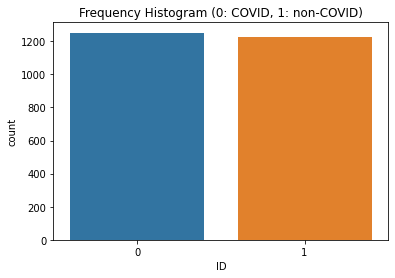

In [5]:
seed = 42
trainDataset = trainDataset.sample(frac=1, replace=False, random_state=seed)
trainDataset = trainDataset.reset_index(drop=True)

sns.countplot(x = "ID", data=trainDataset).set_title("Frequency Histogram (0: COVID, 1: non-COVID)")
trainDataset

### Dataset Sample Visualization

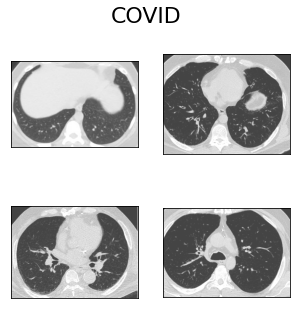

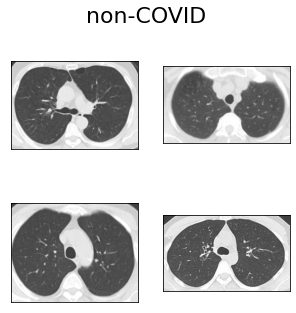

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(5, 5))
    defect_files = trainDataset['File'][trainDataset['Disease Type'] == defect_types].values
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "black")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dataDir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 2, 2)
plot_defects('non-COVID', 2, 2)

### Preprocessing the Dataset

In [7]:
imageSize = 224
def readImage(filePath) :
    return cv2.imread(os.path.join(dataDir, filePath))

def resizeImage(image, imageSize) :
    return cv2.resize(image.copy(), imageSize, interpolation=cv2.INTER_AREA)

In [8]:
trainNumpy = np.zeros((trainDataset.shape[0], imageSize, imageSize, 3))

for i, file in enumerate(trainDataset['File'].values) :
    image = readImage(file)
    if image is not None :
        trainNumpy[i] = resizeImage(image, (imageSize, imageSize))

trainNumpy = trainNumpy / 255.0
print("Train Dataset Shape: ", trainNumpy.shape)

testNumpy = to_categorical(trainDataset['ID'].values, num_classes=2)
print("Test Dataset Shape: ", testNumpy.shape)

Train Dataset Shape:  (2481, 224, 224, 3)
Test Dataset Shape:  (2481, 2)


In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(trainNumpy, testNumpy, test_size=0.2, random_state=seed)
print("X - Train Shape: ", xtrain.shape)
print("X - Test Shape: ", xtest.shape)
print("Y - Train Shape: ", ytrain.shape)
print("Y - Test Shape: ", ytest.shape)

X - Train Shape:  (1984, 224, 224, 3)
X - Test Shape:  (497, 224, 224, 3)
Y - Train Shape:  (1984, 2)
Y - Test Shape:  (497, 2)


### Building the Model and Modifying for Cuckoo Search

In [10]:
def buildModel(imageSize, channels) :
    denseNet = DenseNet121(include_top=False, weights="imagenet")
    input = Input(shape=(imageSize, imageSize, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = denseNet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)
    model = Model(input, output)
    for layer in denseNet.layers:
        layer.trainable = False

    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    return model

In [11]:
channels = 3

model = buildModel(imageSize, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)
checkpoint = ModelCheckpoint('./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5', verbose = 1, save_best_only = True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True)
datagen.fit(xtrain)

plot_model(model, to_file = './Plot_Images/Model_Architecture.png', show_shapes = True, show_layer_names = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

### Training the Dataset with the created Model

In [13]:
BATCH_SIZE = 64
EPOCHS = 30

hist = model.fit(datagen.flow(xtrain, ytrain, batch_size = BATCH_SIZE),
               steps_per_epoch = xtrain.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (xtest, ytest))

Epoch 1/30
31/31 [==============================] - 34s 949ms/step - loss: 0.8245 - accuracy: 0.5988 - val_loss: 0.7206 - val_accuracy: 0.5473

Epoch 00001: val_loss improved from inf to 0.72060, saving model to ./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5
Epoch 2/30
31/31 [==============================] - 21s 661ms/step - loss: 0.7020 - accuracy: 0.6608 - val_loss: 0.6242 - val_accuracy: 0.6479

Epoch 00002: val_loss improved from 0.72060 to 0.62424, saving model to ./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5
Epoch 3/30
31/31 [==============================] - 21s 659ms/step - loss: 0.6183 - accuracy: 0.6930 - val_loss: 0.5487 - val_accuracy: 0.7103

Epoch 00003: val_loss improved from 0.62424 to 0.54873, saving model to ./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5
Epoch 4/30
31/31 [==============================] - 21s 657ms/step - loss: 0.5418 - accuracy: 0.7359 - val_loss: 0.5127 - val_accuracy: 0.7243

Epoch 00004: val_loss impr

In [14]:
model = load_model('./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5')
final_loss, final_accuracy = model.evaluate(xtest, ytest)
print('Final Loss: {:.2f}, Final Accuracy: {:.2f}'.format(final_loss, final_accuracy))

16/16 [==============================] - 3s 91ms/step - loss: 0.3015 - accuracy: 0.8793
Final Loss: 0.30, Final Accuracy: 0.88


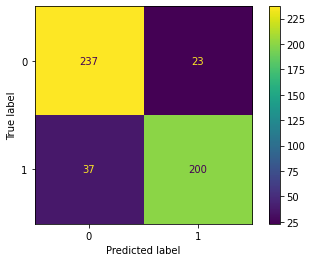

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ypred = model.predict(xtest)
ypred = np.argmax(ypred, axis = 1)
ytest = np.argmax(ytest, axis = 1)
cm = confusion_matrix(ypred, ytest)
cmDisplay = ConfusionMatrixDisplay(cm).plot()

In [24]:
img_file_name = dataDir + '/COVID/Covid (634).png'
img = load_img(img_file_name, grayscale=False, target_size=(224, 224))
disease_class=['Covid-19','Non Covid-19']
x = img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

[0.9070097  0.09299026]
